In [1]:
### Denoising Adverarial Autoencoder (MNIST) : Version 1 : matching q(z|x*) to p(z)
#if n_hidden==2 uses 2D 10-mix gaussian
#if n_hidden==10 uses 10D normal

In [2]:
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, Deconv2DLayer, flatten, reshape, batch_norm
from lasagne.nonlinearities import rectify as relu
from lasagne.nonlinearities import LeakyRectify as lrelu
from lasagne.nonlinearities import sigmoid
from lasagne.layers import get_output, get_all_params, get_output_shape
from lasagne.objectives import binary_crossentropy as bce
from lasagne.objectives import squared_error
from lasagne.updates import adam,sgd

import numpy as np
import theano
from theano import tensor as T
import time
from matplotlib import pyplot as plt 
%matplotlib inline

from skimage.io import imsave

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier as KNN

from ll import ll

floatX=theano.config.floatX

Using gpu device 0: GeForce GT 630 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 4007)


In [3]:
#Options for the network
class options(object):
    def __init__(self):
        self.n_hidden=2     #(10 or 2)
        self.alpha=0.0002   #learning rate
        self.sigma=0.5      #standard deviation of corruption process
        self.batchsize=64   #batch size used for training
        self.epoch=100      #number of traning epochs
        self.upper_bound=0.75 #only train discriminator is the encoder adv loss is less than this upper bound
        self.form='gaussian' #force to use guassian for 2D
myOpts=options()

In [4]:
##Build the networks
def build_net(opts):
    
    #Encoder: x* --> z
    enc=InputLayer(shape=(None,28*28))
    enc=DenseLayer(incoming=enc, num_units=1000, nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=1000,nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=opts.n_hidden,nonlinearity=lrelu(1))
    
    #Decoder z --> x
    dec=InputLayer(shape=(None,opts.n_hidden))
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=28*28,nonlinearity=sigmoid)
    
    #Dsicriminator z--> real(1) or fake(0)
    dis=InputLayer(shape=(None,opts.n_hidden))
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1,nonlinearity=sigmoid)
    
    return enc, dec, dis
    

In [5]:
##Make the training, encoding and sampling theano functions
def prep_train(opts):
    #sigma = variation of the gaussian noise used to corrupt the input
    enc,dec,dis=build_net(opts)
    
    #Symbolic vars
    x=T.matrix('x') #MNIST are saved as vectors
    z=T.matrix('z')

    #The outputs for training:
    rng=T.shared_randomstreams.RandomStreams(np.random.randint(low=1,high=1234))
    corr_x=x+opts.sigma*rng.normal(size=T.shape(x),dtype=floatX) #corrupted x
    enc_x_corr=get_output(enc,corr_x) #enc(x*) encoding corrupted x
    dec_enc_x_corr=get_output(dec,enc_x_corr) #dec(enc(x*)) decoding the encoded input
    p_fake=get_output(dis,enc_x_corr) #D(enc(x)) is decoded x_corr real or fake? fake
    p_real=get_output(dis,z) #D(z) is z real or fake? real
    
    #The outputs for testing:
    samples=get_output(dec,z,deterministic=True) #generated samples
    encoding=get_output(enc,x,deterministic=True) #encoded samples
    reconstruction=get_output(dec,enc_x_corr,deterministic=True) #reconstructed samples

    #The params
    params_enc=get_all_params(enc)
    params_dec=get_all_params(dec)
    params_dis=get_all_params(dis)

    #The loss
    #The reconstruction loss
    J_rec=bce(dec_enc_x_corr,x).mean()

    #The prior matching loss (adv loss)
    J_adv_dis=bce(p_real, T.ones_like(p_real)).mean()+bce(p_fake, T.zeros_like(p_fake)).mean()
    J_adv_enc=bce(p_fake, T.ones_like(p_fake)).mean()

    #The updates
    update_rec=adam(J_rec, params_enc+params_dec,learning_rate=opts.alpha) #update the encoder and decoder w/ reconstruction loss
    update_dis=adam(J_adv_dis, params_dis,learning_rate=opts.alpha) #update the discriminator w/ adversarial loss
    update_enc=adam(J_adv_enc, params_enc,learning_rate=opts.alpha) #update the encoder w/ adversarial loss

    #The theano training functions
    train_rec=theano.function(inputs=[x],outputs=J_rec, updates=update_rec) #trains encoder and decoder using reconstruction loss
    train_dis=theano.function(inputs=[x,z],outputs=J_adv_dis, updates=update_dis) #trains discriminator using adversarial loss
    train_enc=theano.function(inputs=[x],outputs=J_adv_enc, updates=update_enc) #trains encoder only using adversarial loss
    
    #The theano testing functions
    sample=theano.function(inputs=[z],outputs=samples) #draw data samples from trained model
    encode=theano.function(inputs=[x],outputs=encoding) #encode data samples
    reconstruct=theano.function(inputs=[x], outputs=[squared_error(x,reconstruction),reconstruction]) #corrupt and reconstruct
    
    return train_rec,train_dis,train_enc,  sample,encode,reconstruct, enc,dec,dis
    
    

In [6]:
##Load the training, testing and validation datasets
def load_data():
    train,test,val = np.load('InData/mnist.pkl',mmap_mode='r')
    print 'x_train \t | y_train \t| x_test \t | y_test \t| x_val \t| y_val \n----------------------------------------------------------------------------------------'
    print np.shape(train[0]),'\t',np.shape(train[1]),'\t',np.shape(test[0]),'\t',np.shape(test[1]),'\t',np.shape(val[0]),'\t',np.shape(val[1])
    return train[0], train[1], test[0], test[1], val[0], val[1]

(10000, 2)


[-8, 8, -8, 8]

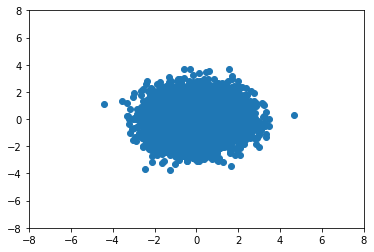

In [7]:
def P_z(size,form=None):
    if form=='gaussian':
        return np.random.normal(size=size).astype(floatX)
        
    if size[1] is 2:
        #samples at 2D 10-giassuain mix
        p=np.random.randint(low=0, high=10, size=(size[0],1))
        samples_x=np.zeros((size[0],1))
        samples_y=np.zeros((size[0],1))

        r=4
        theta=np.pi*2/10
        for i in range(10):
            samples_x+=(p==i)*np.random.normal(loc=r*(np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
            samples_y+=(p==i)*np.random.normal(loc=r*(-np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
        return np.hstack([samples_x,samples_y]).astype(floatX)
    else:
        return np.random.normal(size=size).astype(floatX)


#Examples of samples from the mixutre distribution
try:
    Z=P_z(size=(10000,myOpts.n_hidden),form=myOpts.form)
except AttributeError:
    Z=P_z(size=(10000,myOpts.n_hidden))
print np.shape(Z)
plt.scatter(Z[:,0],Z[:,1])
plt.axis([-8 ,8 ,-8 ,8])

In [8]:
##Training function
def train(opts):
    train_rec,train_dis,train_enc,  sample,encode,reconstruct,  enc,dec,dis=prep_train(opts)
    x_train,y_train,x_test,y_test,x_val,y_val=load_data()
    
    batches=int(float(x_train.shape[0])/opts.batchsize)
    
    #Tally of costs
    cost_rec=[] #reconstruction cost of the encoder, decoder net
    cost_dis=[] #aversarial cost on discriminator
    cost_enc=[] #adversarial cost on encoding
    
    print 'epoch   batch   cost_dis   cost_enc   cost_rec   time '
    for e in range(opts.epoch):
        timer = time.time()
        for b in range(batches):
            #draw from the prior
            Z=P_z(size=(opts.batchsize,opts.n_hidden),form=opts.form)
            X=x_train[b*opts.batchsize:(1+b)*opts.batchsize]
            #train the discriminator
            cost_dis.append(train_dis(X,Z))
            #train the encoder (w/ adversarial) 
            cost_enc.append(train_enc(X))
            #train the autoencer (enc and dec) (w/ reconstruction loss)
            cost_rec.append(train_rec(X))
            
        print "%d \t %d  \t %.3f \t %.3f \t %.3f \t %.2f" % (e,b,cost_dis[-1],cost_enc[-1],cost_rec[-1], time.time()-timer)
    
    return sample,encode,reconstruct, cost_enc,cost_rec,cost_dis
    

In [ ]:
##Training 
sample,encode,reconstruct, cost_enc,cost_rec,cost_dis=train(myOpts)

In [ ]:
#Save all models:
import pickle
dir='DAAE_v1_params'
pickle.dump(sample,open(dir+'/sample.pkl','w'))
pickle.dump(encode,open(dir+'/encode.pkl','w'))
pickle.dump(reconstruct,open(dir+'/reconstruct.pkl','w'))
pickle.dump(myOpts,open(dir+'/myOpts.pkl','w'))
np.save(dir+'/cost_enc.npy',cost_enc)
np.save(dir+'/cost_rec.npy',cost_rec)
np.save(dir+'/cost_dis.npy',cost_dis)

In [9]:
#load all models:
import pickle
dir='DAAE_v1_params'
#dir='../../Expeirments/DAAE_v1/DAAE_1_a/models_v1_DAAE_1_a/'
sample=pickle.load(open(dir+'/sample.pkl','r'))
encode=pickle.load(open(dir+'/encode.pkl','r'))
reconstruct=pickle.load(open(dir+'/reconstruct.pkl','r'))
myOpts=pickle.load(open(dir+'/myOpts.pkl','r'))
cost_enc=np.load(dir+'/cost_enc.npy')
cost_rec=np.load(dir+'/cost_rec.npy')
cost_dis=np.load(dir+'/cost_dis.npy')

print 'sigma:',myOpts.sigma,', n_hidden',myOpts.n_hidden

sigma: 0.5 , n_hidden 10


x_train 	 | y_train 	| x_test 	 | y_test 	| x_val 	| y_val 
----------------------------------------------------------------------------------------
(50000, 784) 	(50000,) 	(10000, 784) 	(10000,) 	(10000, 784) 	(10000,)


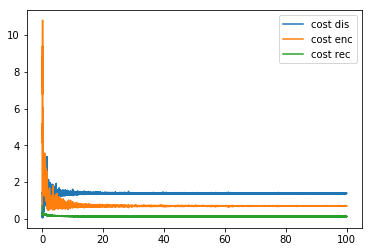

In [10]:
##Training Plots
#Cost plots
x_train,y_train,x_test,y_test,x_val,y_val=load_data()
step=1./int(float(x_train.shape[0])/myOpts.batchsize)
y=np.arange(0,myOpts.epoch,step)
plt.plot(y,cost_dis,label='cost dis')
plt.plot(y,cost_enc,label='cost enc')
plt.plot(y,cost_rec,label='cost rec')
plt.legend()

mean squared error loss: 0.0231294 +/- 0.000820670202374


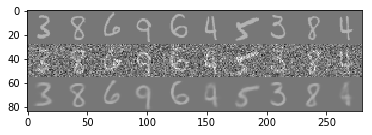

In [11]:
#Apply reconstruction to all the test images
x_rec_loss,x_rec=reconstruct(x_test)
print "mean squared error loss:", np.mean(x_rec_loss), "+/-", np.std(x_rec_loss)/np.sqrt(x_rec_loss.shape[0])

egs=10 #no of random examples to show
x_noise=(x_test[:egs]+np.random.normal(loc=0.0, scale=myOpts.sigma, size=(egs,28*28))).reshape(egs,28,28)
plt.imshow(np.hstack(np.hstack(([x_test[:egs].reshape(egs,28,28),x_noise,x_rec[:egs].reshape(egs,28,28)]))),cmap='gray')
plt.figure()

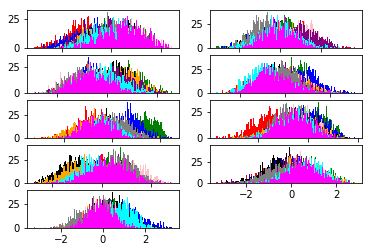

In [12]:
##Encodings
#Encode
colours=['red','green','blue','black','pink','orange','purple','gray','cyan','magenta']
x_enc=encode(x_test)
#Look at histrograms of encodings (For 10D Gaussian)
if myOpts.n_hidden==10:
    plt.figure(1)
    for i in range(9):
        n=520+i+1
        plt.subplot(n)
        for j in range(10):
            plt.hist(x_enc[np.argwhere(y_test==j),i],100, color=colours[j])
if myOpts.n_hidden==2:
    plt.scatter(x_enc[:,0],x_enc[:,1])

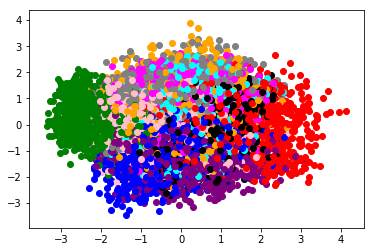

In [13]:
##Show the latent space
colours=['red','green','blue','black','pink','orange','purple','gray','cyan','magenta']
for i in range(x_test.shape[0]):
    if myOpts.n_hidden>2:
        reduced_x_enc=PCA(n_components=2).fit_transform(x_enc)
        plt.scatter(reduced_x_enc[i,0],reduced_x_enc[i,1], color=colours[y_test[i]])
        #plt.title('Training Data')
    else:
        plt.figure(211)
        plt.scatter(encode(x_train)[i,0],encode(x_train)[i,1], color=colours[y_train[i]])
        plt.axis([-9,9,-9,9])
#         #plt.title('Training data')
#         plt.figure(212)
#         plt.scatter(x_enc[i,0], x_enc[i,1],color=colours[y_test[i]])
#         #plt.title('Testing data')

In [14]:
##Classification
#Train a SVM on the features from x_train
enc_train=encode(x_train)
enc_test=encode(x_test)
classifier=SVC().fit(enc_train,y_train) #default rbf kernel
score_test=classifier.score(enc_test,y_test)
score_train=classifier.score(enc_train,y_train)
print "mean test accuracy (SVM RBF kernel) :",score_test*100,'%'
print "mean train accuracy (SVM RBF kernel) :",score_train*100,'%'

mean test accuracy (SVM RBF kernel) : 95.28 %
mean train accuracy (SVM RBF kernel) : 95.764 %


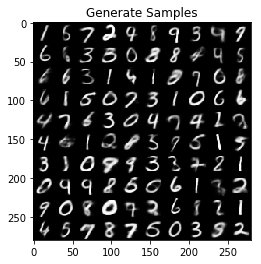

In [15]:
##Samples:
#Draw from the prior and sample (random)
row=col=10
noSamples=row*col
try:
    Z=P_z(size=(noSamples,myOpts.n_hidden),form=myOpts.form)
except AttributeError:
    Z=P_z(size=(noSamples,myOpts.n_hidden)) #deal w/ old and new myOpts
x_samples=sample(Z).reshape(noSamples,28,28)
#display as montage
montage=np.zeros((row*28,col*28))
n=0
for r in range(row):
    for c in range(col):
        montage[r*28:(r+1)*28,c*28:(c+1)*28]=x_samples[n]; n+=1;
plt.imshow(montage,cmap='gray')
plt.title('Generate Samples')

In [16]:
##Likelihood analysis
noSamples=10**4
Z=P_z(size=(noSamples,myOpts.n_hidden))
x_sample=sample(Z)
logL,sigma=ll(x_sample, x_val, x_test)
print "by cross validation sigma*=", sigma
print 'log likelihood of x_test under P(x_fake)=',logL

0.1 471.665535899
0.129154966501 530.056451432
0.16681005372 468.817278615
0.215443469003 349.441507893
0.278255940221 194.980334993
0.35938136638 21.0911877472
0.464158883361 -163.269435302
0.599484250319 -352.840721965
0.774263682681 -544.67060342
1.0 -738.432825767
by cross validation sigma*= 0.129154966501
log likelihood of x_test under P(x_fake)= 521.008404854


In [17]:
##Iterative sampling

In [18]:
#display as montage
def montage(X, row=10,col=10):
    plt.figure()
    montage=np.zeros((row*28,col*28))
    n=0
    for r in range(row):
        for c in range(col):
            montage[r*28:(r+1)*28,c*28:(c+1)*28]=X[n].reshape(28,28); n+=1;
    plt.imshow(montage,cmap='gray')
    plt.title('Generate Samples: After MC')

Iteration: 0
0.1 458.306213485
0.129154966501 536.220619805
0.16681005372 470.221584237
0.215443469003 348.937298281
0.278255940221 193.476944506
by cross validation (only 5 sigmas) sigma*= 0.129154966501
log likelihood of x_test under P(x_fake)= 527.811058699
Iteration: 1
0.1 440.728848061
0.129154966501 525.079291497
0.16681005372 469.340525183
0.215443469003 346.533662686
0.278255940221 193.90707967
by cross validation (only 5 sigmas) sigma*= 0.129154966501
log likelihood of x_test under P(x_fake)= 516.74558296
Iteration: 2
0.1 386.384347906
0.129154966501 483.817386616
0.16681005372 454.618394067
0.215443469003 342.387575588
0.278255940221 191.242640942
by cross validation (only 5 sigmas) sigma*= 0.129154966501
log likelihood of x_test under P(x_fake)= 500.961256692
Iteration: 3
0.1 365.983030134
0.129154966501 479.162727614
0.16681005372 437.291673923
0.215443469003 336.589983848
0.278255940221 189.338254202
by cross validation (only 5 sigmas) sigma*= 0.129154966501
log likelihood

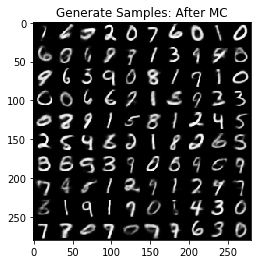

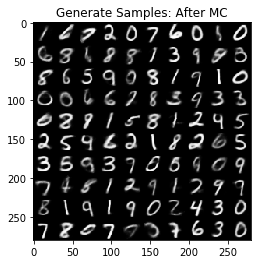

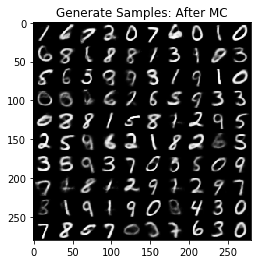

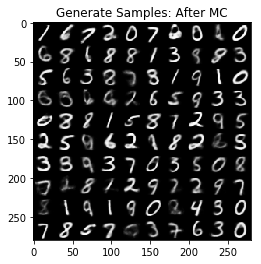

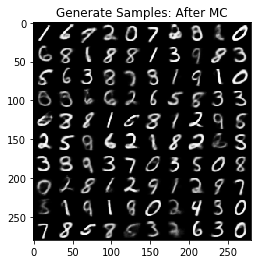

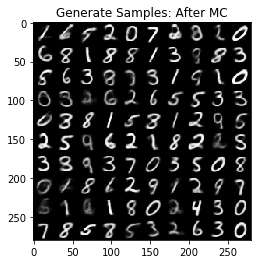

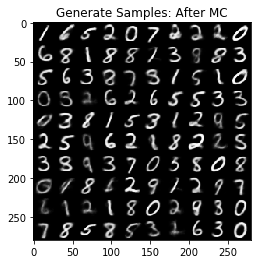

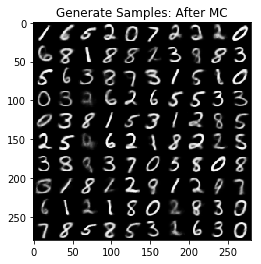

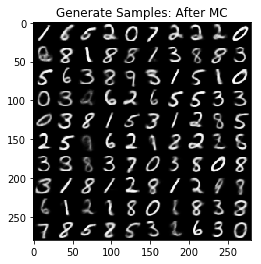

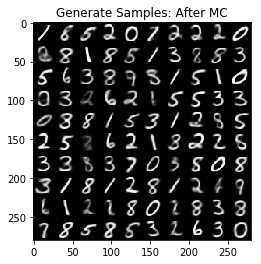

In [19]:
noSamples=10**4
z_0=np.random.normal(size=(noSamples,myOpts.n_hidden)).astype(floatX)
x_t=sample(z_0)
noSteps=10
sigmas=np.logspace(-1.,0,10)[:5]
for t in range(noSteps):
    if(t%10==0 or t<20):
        print 'Iteration:',t
        logL,sigma=ll(x_t, x_val, x_test,sigmas)
        print "by cross validation (only 5 sigmas) sigma*=", sigma
        print 'log likelihood of x_test under P(x_fake)=',logL
        montage(x_t)
        rec_loss,x_t=reconstruct(x_t)

In [20]:
## Calculatinglikelihood
##Likelihood analysis
logL,sigma=ll(x_t, x_val, x_test)
print "by cross validation sigma*=", sigma
print 'log likelihood of x_test under P(x_fake)=',logL

0.1 203.717343121
0.129154966501 386.707078962
0.16681005372 395.817427919
0.215443469003 314.403846827
0.278255940221 176.493727748
0.35938136638 10.7112129988
0.464158883361 -169.422948349
0.599484250319 -357.055800052
0.774263682681 -547.886067983
1.0 -740.67387436
by cross validation sigma*= 0.16681005372
log likelihood of x_test under P(x_fake)= 403.545239311


In [ ]:
exit()